<a href="https://colab.research.google.com/github/Syed-Osama-Hussain/Imagined-Speech-Prediction-from-EEG/blob/master/long_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.io
import os
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, LSTM, Dropout, Input, Reshape, GRU
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers.merge import concatenate
from keras.models import Model, load_model
import keras.backend as K
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!ls "drive/My Drive/dataset/Long_words/"

sub_11b_ch64_l_eog_removed_256Hz.mat  sub_7_ch64_l_eog_removed_256Hz.mat
sub_2b_ch64_l_eog_removed_256Hz.mat   sub_9c_ch64_l_eog_removed_256Hz.mat
sub_6_ch64_l_eog_removed_256Hz.mat


In [ ]:

mat = scipy.io.loadmat("drive/My Drive/dataset/Long_words/sub_2b_ch64_l_eog_removed_256Hz")
end_trial = mat['eeg_data_wrt_task_rep_no_eog_256Hz_end_trial']
last_beep = mat['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']

In [ ]:
print(end_trial[0][0])

[[  2.0756692    3.3451948    1.2805819  ...   1.03499391  -1.8243698
   -1.01871216]
 [ -3.82600849 -11.7789427  -19.90806902 ...  12.53093915   8.48127123
   11.22360224]
 [ -3.00310901  -5.53589825 -10.7160167  ...   8.79775373   5.17229481
    8.20442485]
 ...
 [ -3.28631204 -12.27128688 -21.85336011 ...   7.17226805   4.4037043
    6.18084104]
 [ -1.91263385  -4.37623631  -7.82609212 ...   1.17744386  -3.16380532
    0.43488985]
 [  2.51450495   6.26755729   2.75070428 ...   1.19598115  -4.54512732
   -1.76451922]]


In [ ]:
print(end_trial[1][0])

[[ -1.27735546  -3.82002997  -2.88641743 ...   1.9763067    2.05661518
    1.3593881 ]
 [ -4.90701477  -8.48444293  -5.82129236 ...  -2.30271976  -0.36951821
    1.3378214 ]
 [ -5.40068243  -9.89625475  -7.20670153 ...  -1.60120045   0.36174521
    4.19075407]
 ...
 [ -5.3620891   -9.69451373  -6.31911269 ...  -3.00807071   0.27529782
    2.78197364]
 [ -6.75004416 -11.84629843  -7.65657429 ...  -0.45278445   0.70701181
    1.51307907]
 [ -6.31367576  -8.92761731  -4.09098874 ...   7.03288896   4.97767805
    3.63721799]]


# Cooperate in resting state

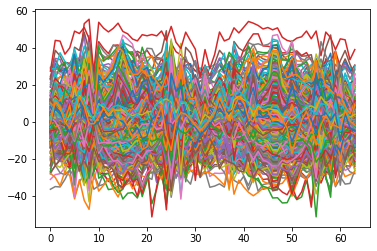

In [ ]:
plt.plot(end_trial[0][0]);

# Cooperate during speech imagery state

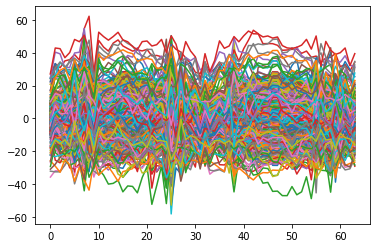

In [ ]:
plt.plot(last_beep[0][0]);

# Independent during resting state

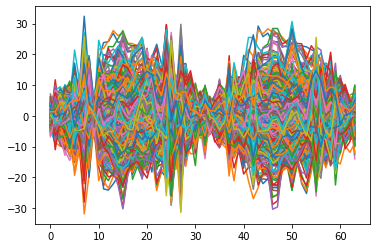

In [ ]:
plt.plot(end_trial[1][0]);

# Independent during speech imagery state

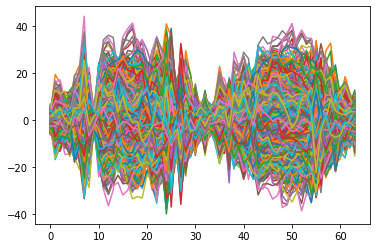

In [ ]:
plt.plot(last_beep[1][0]);

#Covariance Matrix Calculation

In [3]:
def covariance(matrix):
  res_mat = (np.cov(matrix,bias=True))
  return res_mat

#Load Matrices:
Here we load matrices for both classes from all files in the directory.

In [4]:
def loadMatrices(dir):
  matrices_c1 = []
  matrices_c2 = []
  for root,sub,files in os.walk(dir):
    for f in sorted(files):
      if f == "Read_me.txt":
        continue
      mat_file  =  scipy.io.loadmat(os.path.join(root, f))
      end_trial = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_end_trial']
      last_beep = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
      matrices_c1.extend([covariance(matrix) for matrix in end_trial[0]])
      matrices_c1.extend([covariance(matrix) for matrix in last_beep[0]])
      matrices_c2.extend([covariance(matrix) for matrix in end_trial[1]])
      matrices_c2.extend([covariance(matrix) for matrix in last_beep[1]])
  return np.concatenate((np.array(matrices_c1),np.array(matrices_c2)),axis=0)


#Data Preparation

In [5]:
data = loadMatrices("drive/My Drive/dataset/Long_words/")

In [6]:
print(data.shape)

(2000, 64, 64)


In [7]:
labels = np.concatenate((np.zeros(1000),np.ones(1000)),axis=0)
print(labels.shape)

(2000,)


In [8]:
from keras.utils.np_utils import to_categorical
labels = to_categorical(labels, num_classes=2)
print(labels.shape,labels)

(2000, 2) [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [9]:
print(labels)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


#Model Design

In [10]:

model=Sequential()

model.add(Conv1D(filters=64, kernel_size=2, activation="relu" , input_shape=(64,64)))
# model.add(MaxPooling1D(pool_size=6))
model.add(Conv1D(filters=64, kernel_size=4, activation="relu", input_shape=(64,64)))
# model.add(MaxPooling1D(pool_size=6))
model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 63, 64)            8256      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 64)            16448     
_________________________________________________________________
flatten (Flatten)            (None, 3840)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               491648    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 533,122
Trainable params: 533,122
Non-trainable params: 0
__________________________________________________

In [12]:
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#Shuffling and Training

In [10]:
data, labels = shuffle(data, labels)

In [14]:
divide_percent = int(len(data)*0.2)
y_test = labels[0:divide_percent]
x_test = data[0:divide_percent]
train_data = data[divide_percent:len(data)]
train_labels = labels[divide_percent:len(labels)]

In [15]:
print(y_test.shape,x_test.shape,train_data.shape,train_labels.shape)

(400, 2) (400, 64, 64) (1600, 64, 64) (1600, 2)


In [16]:
data, labels = shuffle(data, labels)

In [17]:
model.fit(train_data,train_labels,validation_data=(x_test,y_test),epochs=300,verbose=1)

Epoch 1/300
50/50 [==============================] - 1s 19ms/step - loss: 15.1641 - accuracy: 0.4819 - val_loss: 21.0306 - val_accuracy: 0.5050
Epoch 2/300
50/50 [==============================] - 1s 16ms/step - loss: 7.4627 - accuracy: 0.5019 - val_loss: 31.3523 - val_accuracy: 0.5000
Epoch 3/300
50/50 [==============================] - 1s 16ms/step - loss: 4.6120 - accuracy: 0.4906 - val_loss: 22.9556 - val_accuracy: 0.5025
Epoch 4/300
50/50 [==============================] - 1s 16ms/step - loss: 3.3238 - accuracy: 0.5025 - val_loss: 17.3311 - val_accuracy: 0.4625
Epoch 5/300
50/50 [==============================] - 1s 16ms/step - loss: 2.5657 - accuracy: 0.5044 - val_loss: 10.0703 - val_accuracy: 0.4450
Epoch 6/300
50/50 [==============================] - 1s 16ms/step - loss: 1.8970 - accuracy: 0.5231 - val_loss: 4.3466 - val_accuracy: 0.4475
Epoch 7/300
50/50 [==============================] - 1s 16ms/step - loss: 1.4120 - accuracy: 0.5306 - val_loss: 2.1442 - val_accuracy: 0.4550


#Results

In [18]:
predictions = model.predict(x_test)

In [19]:
np.round(predictions)

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.

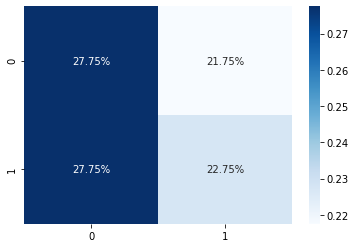

In [20]:
rounded_labels = np.argmax(y_test, axis=1)
rounded_predictions = np.argmax(predictions, axis=1)
cf = confusion_matrix(rounded_labels,rounded_predictions)  # doctest: +SKIP
sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')

In [21]:
print(rounded_predictions)

[1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0
 1 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1
 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 1
 0 0 1 1 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0 1 0 1 0 0 0
 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 1 1 0 1 0 0 1 1 0 0 1 1 0
 0 1 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 0
 1 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 1 0 0 0 1 1 1 0 0 1 1
 0 1 1 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0
 1 0 1 0 0 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 1 0 0 1 0
 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0]


In [22]:
print(rounded_labels)

[0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1
 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 0 0
 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0
 1 1 0 0 1 1 1 0 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0
 1 0 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1
 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 1 1 1 1 1 1 0 1
 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 1 1
 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 0 1 1 0 1 1 0 1 0 1 0 1 1
 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 1 1 1
 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1]


# RNN

In [ ]:

modelRNN = Sequential()
modelRNN.add(GRU(64,activation="relu",return_sequences=True,input_shape=(64,64)))
modelRNN.add(GRU(64,activation="relu"))
modelRNN.add(Dense(64, activation='relu'))
modelRNN.add(Dense(64, activation='relu'))

# modelRNN.add(LSTM(64,activation="relu"))
# modelRNN.add(Dense(64, activation='relu'))
# modelRNN.add(Flatten())
modelRNN.add(Dense(2, activation='softmax'))
modelRNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 64, 64)            24960     
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 130       
Total params: 58,370
Trainable params: 58,370
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelRNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
modelRNN.fit(x_train_final,y_train_final,validation_data=(x_test,y_test),epochs=150,verbose=1)

Epoch 1/150
50/50 [==============================] - 5s 96ms/step - loss: 1.6513 - accuracy: 0.5231 - val_loss: 1.0967 - val_accuracy: 0.5025
Epoch 2/150
50/50 [==============================] - 5s 91ms/step - loss: 11.1796 - accuracy: 0.5194 - val_loss: 1.9779 - val_accuracy: 0.4925
Epoch 3/150
50/50 [==============================] - 5s 100ms/step - loss: 6.6951 - accuracy: 0.5256 - val_loss: 2.5568 - val_accuracy: 0.5025
Epoch 4/150
50/50 [==============================] - 5s 90ms/step - loss: 9.7190 - accuracy: 0.5038 - val_loss: 3.1024 - val_accuracy: 0.4825
Epoch 5/150
50/50 [==============================] - 4s 87ms/step - loss: 20.2911 - accuracy: 0.4956 - val_loss: 4.7972 - val_accuracy: 0.4825
Epoch 6/150
50/50 [==============================] - 4s 88ms/step - loss: 15.0018 - accuracy: 0.5319 - val_loss: 2.7931 - val_accuracy: 0.5100
Epoch 7/150
50/50 [==============================] - 4s 87ms/step - loss: 1.2788 - accuracy: 0.5106 - val_loss: 0.7912 - val_accuracy: 0.5200
Ep

In [ ]:
predictionsRNN = modelRNN.predict(x_test)
np.round(predictionsRNN)

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

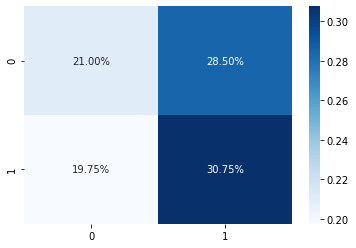

In [ ]:
rounded_labels = np.argmax(y_test, axis=1)
rounded_predictionsRNN = np.argmax(predictionsRNN, axis=1)
cfRNN = confusion_matrix(rounded_labels,rounded_predictionsRNN)  # doctest: +SKIP
sns.heatmap(cfRNN/np.sum(cfRNN), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
print(rounded_predictionsRNN)

[1 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 0
 1 1 1 1 1 0 0 1 0 1 0 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 1 1 0 1 1 0 1 1 0 1 1
 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 1 1
 0 1 1 1 0 1 0 1 1 0 1 0 1 1 0 0 1 1 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1
 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1]


In [ ]:
print(rounded_labels)

[1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 1 1 0 1 1
 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 1 0
 1 0 0 1 1 1 0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 0
 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0
 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1
 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0]


#Final Model

In [11]:

visible = Input(shape=(64,64))
#CNN
cov1 = Conv1D(filters=64, kernel_size=2, activation="relu")(visible)
dropout1 = Dropout(0.25)(cov1)
cov2 = Conv1D(filters=64, kernel_size=4, activation="relu")(dropout1)
dropout2 = Dropout(0.5)(cov2)
newShape = Reshape((60,64), name='newReshape')(dropout2)
f1 = Flatten()(newShape)
d1 = Dense(128, activation='relu')(f1)
d2 = Dense(128, activation='relu')(d1)

#RNN
gru1 = GRU(64,activation="relu",return_sequences=True)(visible)
gru2 = GRU(64,activation="relu")(gru1)
d3 = Dense(64, activation='relu')(gru2)
d4 = Dense(64, activation='relu')(d3)

#Merge
merge = concatenate([d2, d4])

#DAE
encoder1 = Dense(768, activation='relu')(merge)
encoder2 = Dense(96, activation='relu')(encoder1)
decoder1 = Dense(768, activation='relu')(encoder2)
decoder2 = Dense(192, activation='relu')(decoder1)

#FNN
hidden1 = Dense(64, activation='relu')(encoder2)
hidden2 = Dense(64, activation='relu')(hidden1)
output = Dense(2, activation='softmax')(hidden2)
model = Model(inputs=visible, outputs=output)
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 63, 64)       8256        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 63, 64)       0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 60, 64)       16448       dropout[0][0]                    
_______________________________________________________________________________________

In [12]:
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
data, labels = shuffle(data, labels)

In [14]:
divide_percent = int(len(data)*0.2)
y_test = labels[0:divide_percent]
x_test = data[0:divide_percent]
train_data = data[divide_percent:len(data)]
train_labels = labels[divide_percent:len(labels)]

In [15]:
print(y_test.shape,x_test.shape,train_data.shape,train_labels.shape)

(400, 2) (400, 64, 64) (1600, 64, 64) (1600, 2)


Iteration no  0  for training 
Epoch 1/200
50/50 [==============================] - 5s 101ms/step - loss: 2.0167 - accuracy: 0.4863 - val_loss: 0.7909 - val_accuracy: 0.4800
Epoch 2/200
50/50 [==============================] - 5s 91ms/step - loss: 2.5817 - accuracy: 0.5219 - val_loss: 0.7594 - val_accuracy: 0.4925
Epoch 3/200
50/50 [==============================] - 5s 91ms/step - loss: 1.3586 - accuracy: 0.4906 - val_loss: 0.7516 - val_accuracy: 0.5075
Epoch 4/200
50/50 [==============================] - 4s 90ms/step - loss: 7.2043 - accuracy: 0.5056 - val_loss: 0.7636 - val_accuracy: 0.4750
Epoch 5/200
50/50 [==============================] - 4s 90ms/step - loss: 5.5421 - accuracy: 0.5106 - val_loss: 0.7462 - val_accuracy: 0.4800
Epoch 6/200
50/50 [==============================] - 4s 90ms/step - loss: 13.2958 - accuracy: 0.4944 - val_loss: 0.7832 - val_accuracy: 0.5050
Epoch 7/200
50/50 [==============================] - 4s 89ms/step - loss: 4.8780 - accuracy: 0.4712 - val_loss: 0.8

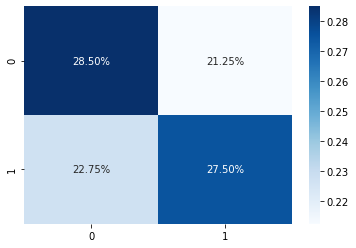

Iteration no  1  for training 
Epoch 1/200
50/50 [==============================] - 4s 89ms/step - loss: 1.3704 - accuracy: 0.5069 - val_loss: 0.7232 - val_accuracy: 0.5375
Epoch 2/200
50/50 [==============================] - 4s 89ms/step - loss: 1.4847 - accuracy: 0.5094 - val_loss: 0.7270 - val_accuracy: 0.5275
Epoch 3/200
50/50 [==============================] - 4s 88ms/step - loss: 3.2020 - accuracy: 0.5000 - val_loss: 0.7505 - val_accuracy: 0.5150
Epoch 4/200
50/50 [==============================] - 4s 89ms/step - loss: 0.9941 - accuracy: 0.5075 - val_loss: 0.7325 - val_accuracy: 0.5200
Epoch 5/200
50/50 [==============================] - 4s 90ms/step - loss: 1.4440 - accuracy: 0.4894 - val_loss: 0.7266 - val_accuracy: 0.5425
Epoch 6/200
50/50 [==============================] - 4s 90ms/step - loss: 1.2010 - accuracy: 0.5219 - val_loss: 0.7132 - val_accuracy: 0.5425
Epoch 7/200
50/50 [==============================] - 4s 89ms/step - loss: 2.9019 - accuracy: 0.5337 - val_loss: 0.712

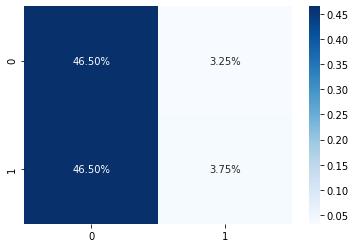

Iteration no  2  for training 
Epoch 1/200
50/50 [==============================] - 4s 88ms/step - loss: 0.7804 - accuracy: 0.5525 - val_loss: 0.7052 - val_accuracy: 0.5000
Epoch 2/200
50/50 [==============================] - 4s 88ms/step - loss: 1.0653 - accuracy: 0.5462 - val_loss: 0.7065 - val_accuracy: 0.4975
Epoch 3/200
50/50 [==============================] - 4s 89ms/step - loss: 1.1376 - accuracy: 0.5450 - val_loss: 0.7094 - val_accuracy: 0.5100
Epoch 4/200
50/50 [==============================] - 4s 87ms/step - loss: 0.7937 - accuracy: 0.5494 - val_loss: 0.7114 - val_accuracy: 0.5075
Epoch 5/200
50/50 [==============================] - 4s 87ms/step - loss: 0.7928 - accuracy: 0.5575 - val_loss: 0.7104 - val_accuracy: 0.5050
Epoch 6/200
50/50 [==============================] - 4s 87ms/step - loss: 1.0593 - accuracy: 0.5469 - val_loss: 0.7094 - val_accuracy: 0.5125
Epoch 7/200
50/50 [==============================] - 4s 86ms/step - loss: 4.9339 - accuracy: 0.5581 - val_loss: 0.710

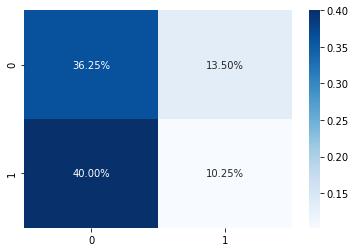

Iteration no  3  for training 
Epoch 1/200
50/50 [==============================] - 5s 95ms/step - loss: 0.7982 - accuracy: 0.6225 - val_loss: 1.0080 - val_accuracy: 0.4625
Epoch 2/200
50/50 [==============================] - 5s 92ms/step - loss: 0.6437 - accuracy: 0.6506 - val_loss: 1.0068 - val_accuracy: 0.4700
Epoch 3/200
50/50 [==============================] - 5s 95ms/step - loss: 0.5860 - accuracy: 0.6212 - val_loss: 1.0163 - val_accuracy: 0.4725
Epoch 4/200
50/50 [==============================] - 5s 94ms/step - loss: 0.6058 - accuracy: 0.6388 - val_loss: 1.0095 - val_accuracy: 0.4725
Epoch 5/200
50/50 [==============================] - 5s 92ms/step - loss: 1.1953 - accuracy: 0.6162 - val_loss: 1.0021 - val_accuracy: 0.4725
Epoch 6/200
50/50 [==============================] - 5s 94ms/step - loss: 0.6519 - accuracy: 0.6250 - val_loss: 1.0077 - val_accuracy: 0.4875
Epoch 7/200
50/50 [==============================] - 5s 93ms/step - loss: 0.6821 - accuracy: 0.6156 - val_loss: 1.008

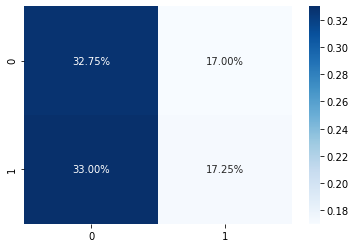

Iteration no  4  for training 
Epoch 1/200
50/50 [==============================] - 4s 85ms/step - loss: 0.6741 - accuracy: 0.6606 - val_loss: 1.2873 - val_accuracy: 0.5000
Epoch 2/200
50/50 [==============================] - 4s 88ms/step - loss: 0.7930 - accuracy: 0.6394 - val_loss: 1.2499 - val_accuracy: 0.5000
Epoch 3/200
50/50 [==============================] - 4s 86ms/step - loss: 0.7369 - accuracy: 0.6550 - val_loss: 1.2652 - val_accuracy: 0.5100
Epoch 4/200
50/50 [==============================] - 4s 84ms/step - loss: 0.6429 - accuracy: 0.6612 - val_loss: 1.2701 - val_accuracy: 0.5200
Epoch 5/200
50/50 [==============================] - 4s 84ms/step - loss: 0.7360 - accuracy: 0.6569 - val_loss: 1.2646 - val_accuracy: 0.5150
Epoch 6/200
50/50 [==============================] - 4s 84ms/step - loss: 0.7706 - accuracy: 0.6600 - val_loss: 1.2599 - val_accuracy: 0.5200
Epoch 7/200
50/50 [==============================] - 4s 85ms/step - loss: 3.6217 - accuracy: 0.6506 - val_loss: 1.246

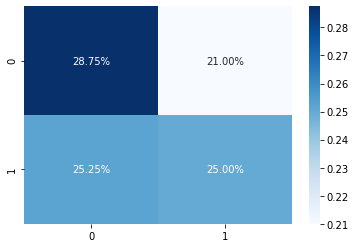

Iteration no  5  for training 
Epoch 1/200
50/50 [==============================] - 4s 83ms/step - loss: 0.5214 - accuracy: 0.7156 - val_loss: 1.5726 - val_accuracy: 0.5300
Epoch 2/200
50/50 [==============================] - 4s 82ms/step - loss: 0.5944 - accuracy: 0.7250 - val_loss: 1.5830 - val_accuracy: 0.5250
Epoch 3/200
50/50 [==============================] - 4s 84ms/step - loss: 0.4876 - accuracy: 0.7381 - val_loss: 1.5809 - val_accuracy: 0.5250
Epoch 4/200
50/50 [==============================] - 4s 81ms/step - loss: 0.5175 - accuracy: 0.7475 - val_loss: 1.6196 - val_accuracy: 0.5350
Epoch 5/200
50/50 [==============================] - 4s 83ms/step - loss: 0.6543 - accuracy: 0.7244 - val_loss: 1.5575 - val_accuracy: 0.5375
Epoch 6/200
50/50 [==============================] - 4s 83ms/step - loss: 0.4878 - accuracy: 0.7337 - val_loss: 1.5683 - val_accuracy: 0.5350
Epoch 7/200
50/50 [==============================] - 4s 82ms/step - loss: 0.5229 - accuracy: 0.7312 - val_loss: 1.570

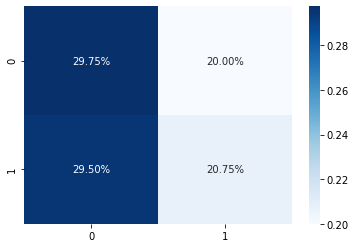

Iteration no  6  for training 
Epoch 1/200
50/50 [==============================] - 4s 85ms/step - loss: 0.5831 - accuracy: 0.7663 - val_loss: 1.8506 - val_accuracy: 0.5100
Epoch 2/200
50/50 [==============================] - 4s 84ms/step - loss: 0.4983 - accuracy: 0.7738 - val_loss: 1.8586 - val_accuracy: 0.5175
Epoch 3/200
50/50 [==============================] - 4s 83ms/step - loss: 0.4665 - accuracy: 0.7706 - val_loss: 1.8605 - val_accuracy: 0.5175
Epoch 4/200
50/50 [==============================] - 4s 84ms/step - loss: 0.4756 - accuracy: 0.7837 - val_loss: 1.8589 - val_accuracy: 0.5125
Epoch 5/200
50/50 [==============================] - 4s 84ms/step - loss: 0.4939 - accuracy: 0.7800 - val_loss: 1.8695 - val_accuracy: 0.5200
Epoch 6/200
50/50 [==============================] - 4s 84ms/step - loss: 0.7199 - accuracy: 0.7812 - val_loss: 1.8618 - val_accuracy: 0.5125
Epoch 7/200
50/50 [==============================] - 4s 85ms/step - loss: 0.5322 - accuracy: 0.7831 - val_loss: 1.887

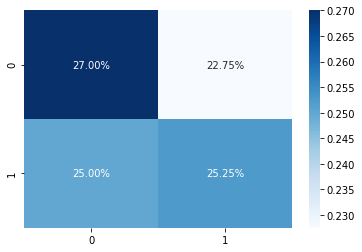

Iteration no  7  for training 
Epoch 1/200
50/50 [==============================] - 4s 84ms/step - loss: 0.4807 - accuracy: 0.8094 - val_loss: 2.0689 - val_accuracy: 0.5125
Epoch 2/200
50/50 [==============================] - 4s 82ms/step - loss: 0.4727 - accuracy: 0.8125 - val_loss: 2.0905 - val_accuracy: 0.5250
Epoch 3/200
50/50 [==============================] - 4s 84ms/step - loss: 0.4189 - accuracy: 0.8131 - val_loss: 2.0995 - val_accuracy: 0.5275
Epoch 4/200
50/50 [==============================] - 4s 85ms/step - loss: 0.4093 - accuracy: 0.8112 - val_loss: 2.0969 - val_accuracy: 0.5250
Epoch 5/200
50/50 [==============================] - 4s 85ms/step - loss: 0.3689 - accuracy: 0.8125 - val_loss: 2.1269 - val_accuracy: 0.5200
Epoch 6/200
50/50 [==============================] - 4s 86ms/step - loss: 0.3750 - accuracy: 0.8188 - val_loss: 2.1171 - val_accuracy: 0.5225
Epoch 7/200
50/50 [==============================] - 4s 84ms/step - loss: 0.8211 - accuracy: 0.8188 - val_loss: 2.125

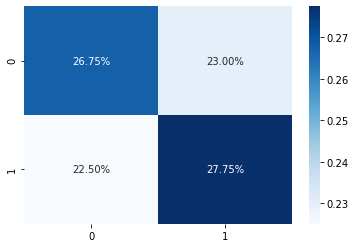

Iteration no  8  for training 
Epoch 1/200
50/50 [==============================] - 5s 93ms/step - loss: 0.3951 - accuracy: 0.8275 - val_loss: 2.1645 - val_accuracy: 0.5475
Epoch 2/200
50/50 [==============================] - 5s 93ms/step - loss: 0.3868 - accuracy: 0.8344 - val_loss: 2.1871 - val_accuracy: 0.5400
Epoch 3/200
50/50 [==============================] - 5s 93ms/step - loss: 0.5978 - accuracy: 0.8338 - val_loss: 2.2328 - val_accuracy: 0.5350
Epoch 4/200
50/50 [==============================] - 5s 94ms/step - loss: 0.4314 - accuracy: 0.8344 - val_loss: 2.1792 - val_accuracy: 0.5375
Epoch 5/200
50/50 [==============================] - 5s 93ms/step - loss: 0.3915 - accuracy: 0.8350 - val_loss: 2.1700 - val_accuracy: 0.5450
Epoch 6/200
50/50 [==============================] - 5s 94ms/step - loss: 0.3554 - accuracy: 0.8394 - val_loss: 2.2148 - val_accuracy: 0.5375
Epoch 7/200
50/50 [==============================] - 5s 93ms/step - loss: 0.3833 - accuracy: 0.8331 - val_loss: 2.193

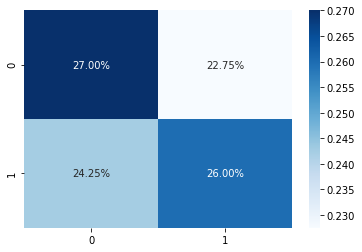

Iteration no  9  for training 
Epoch 1/200
50/50 [==============================] - 5s 94ms/step - loss: 0.3065 - accuracy: 0.8675 - val_loss: 2.5505 - val_accuracy: 0.5275
Epoch 2/200
50/50 [==============================] - 5s 94ms/step - loss: 0.4854 - accuracy: 0.8694 - val_loss: 2.5651 - val_accuracy: 0.5300
Epoch 3/200
50/50 [==============================] - 5s 94ms/step - loss: 0.2856 - accuracy: 0.8644 - val_loss: 2.5388 - val_accuracy: 0.5175
Epoch 4/200
50/50 [==============================] - 5s 94ms/step - loss: 0.2824 - accuracy: 0.8694 - val_loss: 2.5748 - val_accuracy: 0.5325
Epoch 5/200
50/50 [==============================] - 5s 95ms/step - loss: 0.2919 - accuracy: 0.8756 - val_loss: 2.5902 - val_accuracy: 0.5275
Epoch 6/200
50/50 [==============================] - 5s 94ms/step - loss: 0.3591 - accuracy: 0.8687 - val_loss: 2.5786 - val_accuracy: 0.5275
Epoch 7/200
50/50 [==============================] - 5s 94ms/step - loss: 0.3452 - accuracy: 0.8719 - val_loss: 2.637

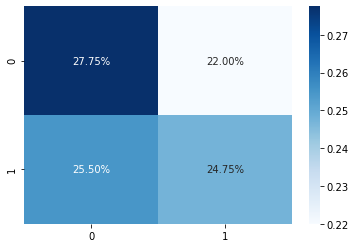

In [16]:
histories = []
for i in range(10):
  print("Iteration no ",i," for training \n=========\n=========\n=========")
  train_data, train_labels = shuffle(train_data, train_labels)
  # divide_percent = (len(train_data)*0.2)
  # x_val = train_data[0:int(divide_percent)]
  # y_val = train_labels[0:int(divide_percent)]
  # x_train = train_data[int(divide_percent):len(train_data)]
  # y_train = train_labels[int(divide_percent):len(train_labels)]
  # print(x_val.shape, y_val.shape, x_train.shape, y_train.shape)

  history = model.fit(train_data,train_labels,validation_data=(x_test,y_test),epochs=200,verbose=1)
  predictions = model.predict(x_test,verbose=0)
  np.round(predictions)
  rounded_labels = np.argmax(y_test, axis=1)
  rounded_predictions = np.argmax(predictions, axis=1)
  cf = confusion_matrix(rounded_labels,rounded_predictions)
  sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')
  histories.append(history)
  # plt.plot(history.history['loss'])
  # plt.plot(history.history['val_loss'])
  # plt.title('model train vs validation loss')
  # plt.ylabel('loss')
  # plt.xlabel('epoch')
  # plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.

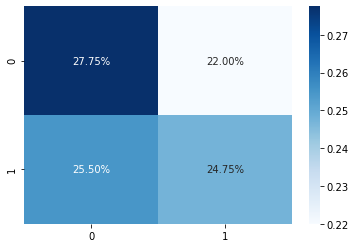

In [17]:
predictions = model.predict(x_test,verbose=0)
rounded_labels = np.argmax(y_test, axis=1)
rounded_predictions = np.argmax(predictions, axis=1)
cf = confusion_matrix(rounded_labels,rounded_predictions)  # doctest: +SKIP
sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')

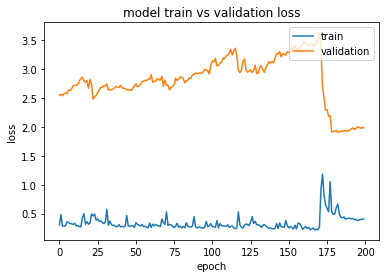

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

#Max Accuracy
loss: 0.1994 - accuracy: 0.9594 - val_loss: 13.8853 - val_accuracy: 0.8000

[Link to commit](https://github.com/Syed-Osama-Hussain/Imagined-Speech-Prediction-from-EEG/blob/ba2289507438f90c51f5e306b716f165cbe06804/long_words.ipynb)

In [19]:
model.save("model_long_words.h5")

Test on unseen data

In [ ]:
model = load_model("drive/My Drive/models/model_long_words.h5")
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 63, 64)       8256        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 60, 64)       16448       conv1d[0][0]                     
__________________________________________________________________________________________________
newReshape (Reshape)            (None, 60, 64)       0           conv1d_1[0][0]                   
_______________________________________________________________________________________

In [ ]:
def loadTestMatrices(data):
  matrices_c1 = []
  matrices_c1.extend([covariance(matrix) for matrix in data[0]])
  return np.array(matrices_c1)

In [ ]:
test_mat = scipy.io.loadmat("drive/My Drive/dataset/Short_Long_words/sub_1c_ch64_sl_eog_removed_256Hz_bw20")
last_beep = test_mat['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
test_data = loadTestMatrices(last_beep)
print(test_data.shape)

(100, 64, 64)


In [ ]:
test_labels = np.zeros(100)
print(test_labels)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
from keras.utils.np_utils import to_categorical
test_labels = to_categorical(test_labels, num_classes=2)
print(test_labels.shape,test_labels)

(100, 2) [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


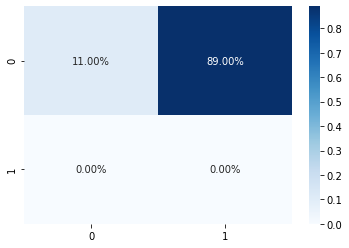

In [ ]:
  predictions_test = model.predict(test_data,verbose=0)
  np.round(predictions_test)
  rounded_labels_test = np.argmax(test_labels, axis=1)
  rounded_predictions_test = np.argmax(predictions_test, axis=1)
  cf_test = confusion_matrix(rounded_labels_test,rounded_predictions_test)  # doctest: +SKIP
  sns.heatmap(cf_test/np.sum(cf_test), annot=True, fmt='.2%', cmap='Blues')


In [ ]:
print(rounded_predictions_test)

[0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
print(rounded_labels_test)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
